# Aug ??st, 2021 (play boot)

**Motivation**: SVINET <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [3]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'cosine',
    'graph_type': 'real',
}
mice = Mice(Config(128))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

k = 6
p = 20
figs_dir = [
    mice.cfg.results_dir,
    'SVINET',
    'figs_combined',
    '-'.join([
        f"{svinet_props.get('graph_type', 'real')}",
        f"p{p}",
        f"k{k}",
    ]),
]
figs_dir = pjoin(*figs_dir)
os.makedirs(figs_dir, exist_ok=True)
print(figs_dir)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6

## Align loaded fits using svinet.gam

In [4]:
svinet = SVINET(mice, k, p, 'sub-SLC')
result = align_svinet_group(mice, k=k, p=p, **svinet_props)
list(result)

current expt: 'p20'

['perms', 'gam', 'pi', 'gamma_all', 'svinet_all']

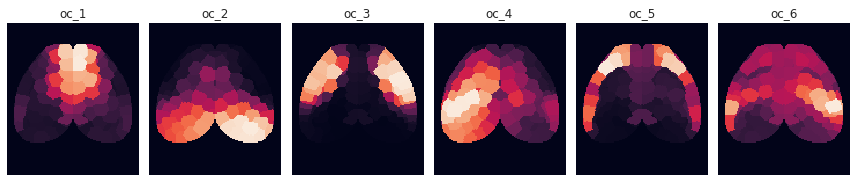

In [5]:
fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))
gam_arr = svinet.pi2arr(result['pi'], cortex_only=True)
for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(gam_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

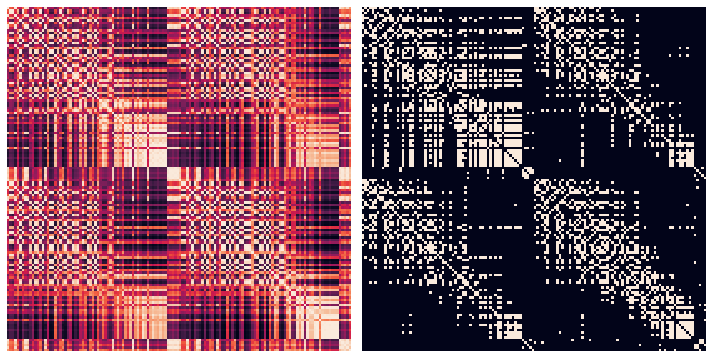

In [6]:
fig, axes = create_figure(1, 2, (10, 7))
d = sp_dist.pdist(result['pi'].T, metric='cosine')
d = sp_dist.squareform(d)
im = axes[0].imshow(dist2sim(d))

axes[1].imshow(svinet.adjacencies[20].astype(bool))
remove_ticks(axes)
plt.show()

In [8]:
fix_idx = np.concatenate([
    np.array(list(v.values())).reshape(1, -1)
    for v in result['perms'].values()
])
ctr = {}
for i in range(k):
    ctr[i] = collections.Counter(fix_idx[:, i]).most_common()
ctr

{
    0: [(0, 13), (7, 9), (6, 3), (8, 3), (3, 2)],
    1: [(1, 19), (0, 5), (3, 2), (6, 2), (8, 1), (7, 1)],
    2: [(2, 28), (8, 1), (6, 1)],
    3: [(0, 11), (3, 9), (6, 5), (7, 2), (8, 1), (1, 1), (5, 1)],
    4: [(4, 27), (3, 1), (8, 1), (6, 1)],
    5: [(5, 26), (8, 2), (3, 1), (7, 1)],
    6: [(3, 12), (8, 9), (6, 4), (4, 2), (7, 1), (5, 1), (1, 1)],
    7: [(8, 9), (7, 8), (6, 8), (3, 3), (5, 1), (2, 1)],
    8: [(1, 9), (7, 8), (6, 6), (8, 3), (5, 1), (0, 1), (2, 1), (4, 1)]
}

In [7]:
### Run below to see if they are aligned goodly

  0%|          | 0/30 [00:00<?, ?it/s]

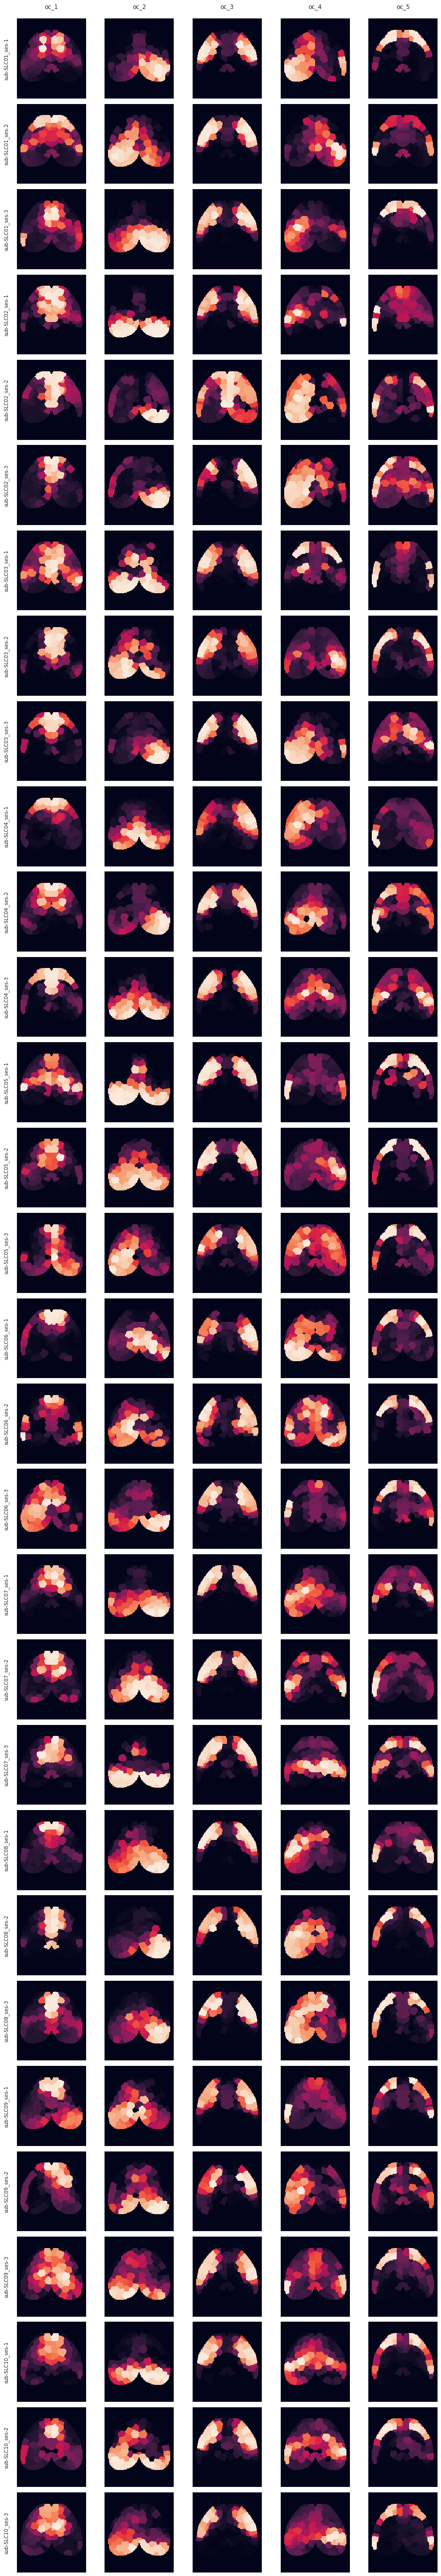

In [8]:
nrows = len(result['gamma_all'])
fig, axes = create_figure(nrows, k, (13, 2.4 * nrows))

for i, (key, gam) in tqdm(enumerate(result['gamma_all'].items()), total=nrows):
    gam_arr = svinet.pi2arr(gam, cortex_only=True)
    for j, idx in enumerate(range(1, k + 1)):
        im = axes[i, j].imshow(gam_arr[idx], cmap='rocket', vmin=0)
        # plt.colorbar(im, ax=axes[i, j], shrink=0.5)
        if i == 0:
            axes[i, j].set_title(f"oc_{idx}\n")
        if j == 0:
            axes[i, j].set_ylabel(f"{key}\n")
remove_ticks(axes)
plt.show()

## BOOTSTRAP

In [7]:
import re

def _extract_seed(x):
    x = next(e for e in str(x).split('-') if 'seed' in e)
    x = re.sub(r"\D", "", x)
    return int(x)

In [8]:
# find shared seeds

seeds_shared = set(range(1, 1000 + 1))
for sub in mice.cfg.sub_ids:
    data_ses = []
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        df = result['svinet_all'][key].pi_cut_df
        s = list(map(_extract_seed, df['run']))
        seeds_shared.intersection_update(set(s))
len(seeds_shared)

835

In [9]:
intervals = None

data_all = []
for sub in tqdm(mice.cfg.sub_ids):
    data_ses = []
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        df = result['svinet_all'][key].pi_cut_df.copy()
        if intervals is None:
            intervals = df.interval.unique()
        df = pd.concat([pd.DataFrame(columns=['seed']), df], axis=1)
        df['seed'] = list(map(_extract_seed, df['run']))
        df = df.loc[df['seed'].isin(seeds_shared)]
        df = df.set_index([df['seed'], df['oc_idx'], df['interval']])
        df = df.drop(columns=['run', 'seed', 'oc_idx', 'interval', 'count'])
        data = df.unstack().values
        data = data.reshape((len(seeds_shared), k, len(intervals)))
        data_ses.append(np.expand_dims(data, axis=0))
    data_ses = np.concatenate(data_ses)
    data_all.append(np.expand_dims(data_ses, axis=0))
data_all = np.concatenate(data_all)
data_all.shape

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 3, 835, 6, 10)

In [ ]:
n_boot = int(1e6)
avg_seeds = True

booted = bootstrap(
    data=data_all,
    n_boot=n_boot,
    avg_seeds=avg_seeds,
)
booted.shape

  0%|          | 0/1000000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.01: [0.005, 99.995],
}
figs = []
sups = []
for ci, whisk_val in whisk.items():
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * 10 * n_boot,
                'oc_idx': [i + 1] * 10 * n_boot,
                'mean': booted[..., i, j].ravel(),
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            fill=True,
            alpha=0.05,
            lw=2,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'kde-boot',
    f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

In [ ]:
ci = [99.99, 99.9, 99.0, 95.0]
percentiles = [(100 - c) / 2 for c in ci]
percentiles += [50] + [100 - e for e in percentiles[::-1]]
percentiles = [np.round(e, 3) for e in percentiles]
val = np.percentile(
    a=booted,
    q=percentiles,
    axis=0,
)
dlist = []
for i in range(k):
    for j, intvl in enumerate(intervals):
        _base = {
            'interval': [intvl] * len(ci),
            'oc_idx': [i + 1] * len(ci),
            'ci': ci, 
        }
        dlist.append({
            'label': ['lower'] * len(ci),
            'value': val[:4, i, j],
            **_base,
        })
        dlist.append({
            'label': ['median'] * len(ci),
            'value': [val[4, i, j]] * len(ci),
            **_base,
        })
        dlist.append({
            'label': ['higher'] * len(ci),
            'value': val[-4:, i, j],
            **_base,
        })
df_boot = pd.DataFrame(merge_dicts(dlist))

In [ ]:
fg = sns.catplot(
    data=df_boot.loc[df_boot.label == 'lower'],
    x='interval',
    y='value',
    hue='oc_idx',
    kind='bar',
    col='ci',
    col_wrap=2,
    palette=svinet.colors,
    aspect=1.1,
    size=5,
    ci=None,
)
for i, ax in enumerate(fg.axes.ravel()):
    _df = df_boot.loc[
        (df_boot.label == 'median') &
        (df_boot.ci == df_boot.ci.unique()[i])
    ]
    sns.stripplot(
        data=_df,
        x='interval',
        y='value',
        hue='oc_idx',
        alpha=0.9,
        dodge=True,
        ax=ax,
    )
    ax.get_legend().remove()
    ax.grid(ls=':')
    ax.tick_params(axis='x', rotation=-90)
    ax.set_title(ax.title.get_text() + ' %', fontsize=15)
    if i < 2:
        ax.set_xlabel('')
    
file = pjoin(figs_dir, f"ci-lower-group_seeds-avg_bins{len(intervals)}-boot{n_boot:1.0e}.pdf")
fg.fig.savefig(file, bbox_inches='tight')

## New, correct Fig

In [ ]:
real_sample = data_all.mean(2).mean(1)

real_sample.shape, data_all.shape, booted.shape

In [ ]:
dlist1, dlist2 = [], []
for i in range(k):
    for j, intvl in enumerate(intervals):
        dlist1.append({
            'condition': ['real'] * len(real_sample),
            'interval': [intvl] * len(real_sample),
            'oc_idx': [i + 1] * len(real_sample),
            'mean': real_sample[:, i, j],
        })
        dlist2.append({
            'condition': ['boot'] * len(booted),
            'interval': [intvl] * len(booted),
            'oc_idx': [i + 1] * len(booted),
            'mean': booted[:, i, j],
        })
df_real = pd.DataFrame(merge_dicts(dlist1))
df_boot = pd.DataFrame(merge_dicts(dlist2))

In [ ]:
df_real.shape, df_boot.shape

In [ ]:
props_boot = {
    'boxprops': {'color': 'none', 'edgecolor': 'k', 'linewidth': 1},
    'medianprops': {'color': 'none', 'linewidth': 0},
    'whiskerprops': {'color': 'k', 'linewidth': 1},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
props_real = {
    'boxprops': {'color': 'none', 'edgecolor': 'none', 'linewidth': 0},
    'medianprops': {'color': 'k', 'linewidth': 1.5},
    'whiskerprops': {'color': 'none', 'linewidth': 0},
    'capprops': {'color': 'none', 'linewidth': 0},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "X",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "8",
}

figs, sups = [], []
cis = [100, 99.99, 99.9, 99.0, 95.0][::-1]
for ci in tqdm(cis):
    lower = np.round((100 - ci) / 2, 3)
    higher = np.round(100 - (100 - ci) / 2, 3)
    
    nrows = 2
    ncols = int(np.ceil(k / nrows))
    fig, axes = create_figure(
        nrows=nrows,
        ncols=ncols,
        figsize=(13.5, 11),
        style='ticks',
        sharex='all',
        sharey='all',
        reshape=True,
    )

    for ax, oc_idx in zip(axes.ravel(), range(1, k + 1)):
        _df = df_boot.loc[df_boot.oc_idx == oc_idx]
        sns.boxplot(
            data=_df,
            x='interval',
            y='mean',
            palette='turbo',
            whis=[lower, higher],
            showfliers=False,
            ax=ax,
            **props_boot,
        )

        _df = df_real.loc[df_real.oc_idx == oc_idx]
        sns.stripplot(
            x='interval',
            y='mean',
            data=_df,
            palette='turbo',
            size=6,
            alpha=0.5,
            linewidth=0.0,
            ax=ax,
        )
        sns.boxplot(
            data=_df,
            x='interval',
            y='mean',
            palette='turbo',
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=ax,
            **props_real,
        )
        ax.axhline(0, color='dimgrey', lw=0.8, ls='--')
        ax.grid(ls=':')
        ax.tick_params(axis='x', rotation=-90)
        ax.set_title(f"OC{oc_idx}", fontsize=13)
        if (oc_idx - 1) % ncols == 0:
            ax.set_ylabel('mean percentage', fontsize=13)
        else:
            ax.set_ylabel('')
    _ = trim_axs(axes, k)
    msg = f"ci = {ci} % whiskers: [{lower}, {higher}]\n"
    msg += "median, mean and scatter points: 'actual' sample\nwhiskers, caps: 'bootstrapped' samples"
    sup = fig.suptitle(msg, fontsize=17, y=1.05)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'group',
    f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')